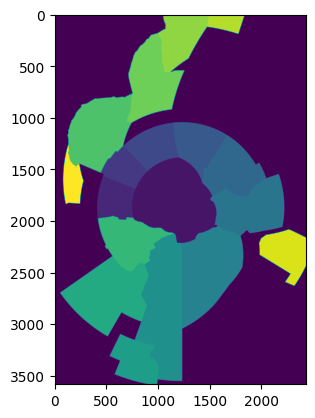

In [9]:
from pyhdf.SD import SD, SDC
import os
import matplotlib.pyplot as plt
import xarray as xr
import pyproj

folder = "/uio/hume/student-u37/fslippe/data/land_sea_ice_mask/"

ds = (xr.open_dataset(folder + "NSIDC-0780_SeaIceRegions_PS-N3.125km_v1.0.nc"))
plt.imshow(ds["sea_ice_region"])

In [2]:
data_crs = pyproj.Proj(proj='laea', lat_0=90, lon_0=0, x_0=0, y_0=0, ellps='WGS84')
lonlat_crs = pyproj.Proj(proj='latlong', datum='WGS84')

In [3]:
desired_lon, desired_lat= -5, 60  # example lon/lat values
x, y = pyproj.transform(lonlat_crs, data_crs, desired_lon, desired_lat)

# Extract the value from the dataset using the nearest x, y
value = ds['sea_ice_region'].sel(x=x, y=y, method='nearest').values

print(value)



"""
ocean_no_region_specified
central_arctic
beaufort_sea
chukchi_sea
east_siberian_sea
laptev_sea
kara_sea
barents_sea
east_greenland_sea
baffin_bay_and_labrador_seas
gulf_of_st_lawrence
hudson_bay
canadian_archipelago
bering_sea
sea_of_okhotsk
sea_of_japan
bohai_and_yellow_seas
baltic_sea
gulf_of_alaska
"""


0.0


/tmp/ipykernel_2787383/3889779893.py:2: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(lonlat_crs, data_crs, desired_lon, desired_lat)


'\nocean_no_region_specified\ncentral_arctic\nbeaufort_sea\nchukchi_sea\neast_siberian_sea\nlaptev_sea\nkara_sea\nbarents_sea\neast_greenland_sea\nbaffin_bay_and_labrador_seas\ngulf_of_st_lawrence\nhudson_bay\ncanadian_archipelago\nbering_sea\nsea_of_okhotsk\nsea_of_japan\nbohai_and_yellow_seas\nbaltic_sea\ngulf_of_alaska\n'

In [4]:
import xarray as xr
import pyproj
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load the dataset

# Define the coordinate transformation
data_crs = pyproj.Proj(proj='laea', lat_0=90, lon_0=0, x_0=0, y_0=0, ellps='WGS84')
lonlat_crs = pyproj.Proj(proj='latlong', datum='WGS84')

# Convert lon-lat boundaries to x-y
lon_min, lat_min = -35, 60
lon_max, lat_max = 35, 82

x_min, y_min = pyproj.transform(lonlat_crs, data_crs, lon_min, lat_min)
x_max, y_max = pyproj.transform(lonlat_crs, data_crs, lon_max, lat_max)

# Slice the dataset
subset = ds['sea_ice_region'].sel(x=slice(x_min, x_max), y=slice(y_max, y_min))


/tmp/ipykernel_2787383/2289364438.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_min, y_min = pyproj.transform(lonlat_crs, data_crs, lon_min, lat_min)
/tmp/ipykernel_2787383/2289364438.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_max, y_max = pyproj.transform(lonlat_crs, data_crs, lon_max, lat_max)


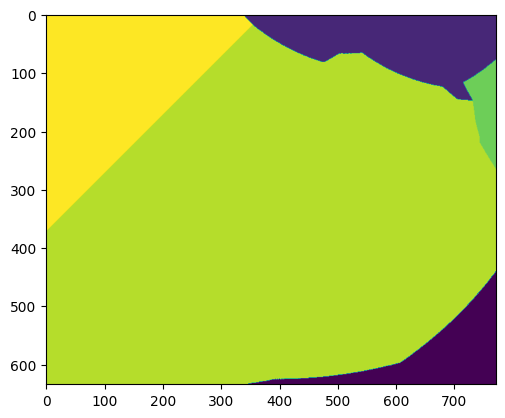

In [7]:
plt.imshow(subset)

In [ ]:

# Define your projection
projection = ccrs.PlateCarree()  # Using Plate Carree in this example, you can choose another

# Plotting
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': projection})
subset.plot(ax=ax, transform=ccrs.PlateCarree())
# ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
# ax.coastlines()
# plt.show()
